In [ ]:
conda install -c conda-forge glpk

In [ ]:
conda install -c conda-forge cbc

In [10]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Load data into a Pandas DataFrame
data = pd.read_csv(r'D:\Polit\Seminar (Energy Econ)\dCFdata.csv')

# Define the objective function
def obj(x):
    return 4000000 * x[0] + 3000000 * x[1] + 4600000 * x[2]

# Define the constraint function
def cons(x):
    return [data['CF_pv'][i] * x[0] + data['CF_on'][i] * x[1] + data['CF_of'][i] * x[2] - data['d'][i] for i in range(len(data))]

# Define the initial guess
x0 = [5000, 5000, 5000]

# Define the bounds for the variables
bounds = [(0, None), (0, None), (0, None)]

# Define the optimization problem
res = minimize(obj, x0, method='SLSQP', bounds=bounds, constraints={'type': 'eq', 'fun': cons})

# Print the results
print(res)

ValueError: negative dimensions are not allowed

In [1]:
pip install pyomo

Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np
import pandas as pd

from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.core import Constraint

Static model, when alpha = 0

In [3]:
# Load data into a Pandas DataFrame
data = pd.read_csv(r'D:\Polit\Seminar (Energy Econ)\dCFdata.csv')

# Create a Pyomo model
model = ConcreteModel()

# Define the sets
model.hours = Set(initialize=data.index, doc='Set of hours')

# Define the variables
model.N_pv = Var(domain=NonNegativeReals, initialize=0)
model.N_on = Var(domain=NonNegativeReals, initialize=0)
model.N_of = Var(domain=NonNegativeReals, initialize=0)
model.C = Var(model.hours, domain=NonNegativeReals)

# Define the parameters
model.k_ipv = Param(default=40)
model.k_ion = Param(default=30)
model.k_iof = Param(default=46)
model.CF_pv = Param(model.hours, initialize=data['CF_pv'].to_dict())
model.CF_on = Param(model.hours, initialize=data['CF_on'].to_dict())
model.CF_of = Param(model.hours, initialize=data['CF_of'].to_dict())

# Define the constraint
model.d = Constraint(model.hours, rule=lambda model, h: model.CF_pv[h] * model.N_pv +
                                                   model.CF_on[h] * model.N_on +
                                                   model.CF_of[h] * model.N_of == data['d'][h] + model.C[h])

# Define the objective function
model.Z = Objective(expr=model.k_ipv * model.N_pv +
                   model.k_ion * model.N_on +
                   model.k_iof * model.N_of)

# Solve the optimization problem
solver = SolverFactory('glpk')
solver.solve(model)

# Access the solution
print("N_pv =", model.N_pv())
print("N_on =", model.N_on())
print("N_of =", model.N_of())
print("Z =", model.Z())


N_pv = 32315.4468498914
N_on = 352866.485014813
N_of = 517826.2190146
Z = 35698618.499111645


Dynamic model with investment costs

In [14]:
# Load data into a Pandas DataFrame
data = pd.read_csv(r'D:\Polit\Seminar (Energy Econ)\dCFdatavd_p.csv')

# Create a Pyomo model
model = ConcreteModel()

# Define the sets
model.hours = Set(initialize=data.index, doc='Set of hours')

# Define the parameters
model.k_ipv = Param(default=435500)
model.k_ion = Param(default=1252525)
model.k_iof = Param(default=3458333)
model.k_vv2g = Param(default=226.56)   #226.56)
model.eta_charge = Param (default=0.924)
model.eta_discharge = Param(default=0.903)
model.E_s = Param(default=160425)
model.alpha = Param(default=1)

#Define data
model.CF_pv = Param(model.hours, initialize=data['CF_pv'].to_dict())
model.CF_on = Param(model.hours, initialize=data['CF_on'].to_dict())
model.CF_of = Param(model.hours, initialize=data['CF_of'].to_dict())
model.pv2g = Param(model.hours, initialize=data['pv2g'].to_dict())
model.d_ev = Param(model.hours, initialize=data['d_ev'].to_dict())
#model.k_vv2g = Param(model.hours, initialize=data['k_vv2g'].to_dict())

# Define the variables
model.N_pv = Var(domain=NonNegativeReals, initialize=0)
model.N_on = Var(domain=NonNegativeReals, initialize=0)
model.N_of = Var(domain=NonNegativeReals, initialize=0)
model.V = Var(model.hours, domain=NonNegativeReals)
model.V_charge = Var(model.hours, domain=NonNegativeReals)
model.V_discharge = Var(model.hours, domain=NonNegativeReals)
model.C = Var(model.hours, domain=NonNegativeReals)

# Market balance constraints
model.d1 = Constraint(model.hours, rule=lambda model, h: model.CF_pv[h] * model.N_pv +
                                                   model.CF_on[h] * model.N_on +
                                                   model.CF_of[h] * model.N_of + model.V_discharge[h] == data['d'][h] + model.C[h])

#State of charge constraint
def s1_constraint(model,h):
    if h == model.hours.first():
        return model.V[h] == 0*model.alpha*model.E_s / 2
    else: 
        return model.V[h] == model.V[h-1] + model.eta_charge * model.V_charge[h] - model.V_discharge[h]/model.eta_discharge - model.alpha*data['d_ev'][h]
model.s1 = Constraint(model.hours, rule = s1_constraint)

"""No free lunch"""
model.s2 = Constraint(rule=lambda model:  model.V[model.hours.first()] == model.V[model.hours.last()])

"""Maximum energy storage must be less or equal to capacity"""
model.s3 = Constraint(model.hours, rule=lambda model, h: model.V[h] <= model.alpha*model.E_s)

# Charging and discharging constraints
""" Maximum discharge rate within a single hour """
model.disc1 = Constraint(model.hours, rule=lambda model, h: model.V_discharge[h] <= model.alpha*data['pv2g'][h])

""" Maximum charge rate within a single hour """
model.char1 = Constraint(model.hours, rule=lambda model, h: model.V_charge[h] <= model.alpha*data['pv2g'][h])

# Define objective function
def obj_expression(model):
    return model.k_ipv * model.N_pv + model.k_ion * model.N_on + model.k_iof * model.N_of + model.k_vv2g * sum(model.V_discharge[h] for h in model.hours)

model.Z = Objective(expr=obj_expression(model), sense=minimize)

# Solve the optimization problem
solver = SolverFactory('cbc')
solver.solve(model)

# Access the solution
print("N_pv =", model.N_pv())
print("N_on =", model.N_on())
print("N_of =", model.N_of())
print("Z =", model.Z())

# Access V_discharge and C
V_values = [model.V[h]() for h in model.hours]
V_charge_values = [model.V_charge[h]() for h in model.hours]
V_discharge_values = [model.V_discharge[h]() for h in model.hours]
C_values = [model.C[h]() for h in model.hours]
G_off_values = [data['CF_of'][h]*model.N_of() for h in model.hours]
G_on_values = [data['CF_on'][h]*model.N_on() for h in model.hours]
G_pv_values = [data['CF_pv'][h]*model.N_pv() for h in model.hours]
d_values = [data['d'][h] for h in model.hours]

print("V =", V_values)
print("V_charge=", V_charge_values)
print("V_discharge=", V_discharge_values)
print("C =", C_values)
print("G_off =", G_off_values)
print("G_on =", G_on_values)
print("G_pv =", G_pv_values)
print("d =", d_values)

    cbc


ApplicationError: No executable found for solver 'cbc'

In [13]:
data = pd.read_csv(r'D:\Polit\Seminar (Energy Econ)\dCFdatavd_p.csv')
data

,d,CF_pv,CF_on,CF_of,d_ev,pv2g,k_vv2g
0,3611.793213,0.000042,0.270233,0.820555,143.212028,7053.823318,48.324998
1,3600.316773,0.000039,0.284314,0.824822,315.925733,6893.163999,41.330002
2,3490.424804,0.000039,0.259770,0.835830,261.218739,6944.052772,42.700001


In [28]:
# Load data into a Pandas DataFrame
data = pd.read_csv(r'D:\Polit\Seminar (Energy Econ)\dCFdatavd_p.csv')

# Create a Pyomo model
model = ConcreteModel()

# Define the sets
model.hours = Set(initialize=data.index, doc='Set of hours')

# Define the parameters
model.k_ipv = Param(default=435500)
model.k_ion = Param(default=1252525)
model.k_iof = Param(default=3458333)
model.k_vv2g = Param(default=226.56)
model.eta_charge = Param (default=0.924)
model.eta_discharge = Param(default=0.903)
model.E_s = Param(default=160425)
model.alpha = Param(default=0.5)

#Define data
model.CF_pv = Param(model.hours, initialize=data['CF_pv'].to_dict())
model.CF_on = Param(model.hours, initialize=data['CF_on'].to_dict())
model.CF_of = Param(model.hours, initialize=data['CF_of'].to_dict())
model.pv2g = Param(model.hours, initialize=data['pv2g'].to_dict())
model.d_ev = Param(model.hours, initialize=data['d_ev'].to_dict())
model.d = Param(model.hours, initialize=data['d'].to_dict())

# Define the variables
model.N_pv = Var(domain=NonNegativeReals, initialize=0)
model.N_on = Var(domain=NonNegativeReals, initialize=0)
model.N_of = Var(domain=NonNegativeReals, initialize=0)
model.V = Var(model.hours, domain=NonNegativeReals, initialize=1000)
model.V_charge = Var(model.hours, domain=NonNegativeReals)
model.V_discharge = Var(model.hours, domain=NonNegativeReals)
model.C = Var(model.hours, domain=NonNegativeReals)

"""
# Market balance constraints hourly
model.d1 = Constraint(model.hours, rule=lambda model, h: model.CF_pv[h] * model.N_pv +
                                                   model.CF_on[h] * model.N_on +
                                                   model.CF_of[h] * model.N_of + model.V_discharge[h] == model.d[h] + model.C[h])
"""
"""
def s0_constraint(model, h):
    return model.V[0] == 100 + model.eta_charge * model.V_charge[0] - model.V_discharge[0]/model.eta_discharge - model.alpha*model.d_ev[0]
model.s0 = Constraint(model.hours, rule = s0_constraint)

def s1_constraint(model, h):
    return model.V[1] == model.V[0] + model.eta_charge * model.V_charge[1] - model.V_discharge[1]/model.eta_discharge - model.alpha*model.d_ev[1]
model.s1 = Constraint(model.hours, rule = s1_constraint)

def s2_constraint(model, h):
    return model.V[2] == 100 + model.eta_charge * model.V_charge[2] - model.V_discharge[2]/model.eta_discharge - model.alpha*model.d_ev[2]
model.s2 = Constraint(model.hours, rule = s2_constraint)
"""

#def s1_constraint(model, h):
    #return model.V[h+1] == model.V[h] + model.eta_charge * model.V_charge[h+1] - model.V_discharge[h+1]/model.eta_discharge - model.alpha*model.d_ev[h+1]
#model.s1 = Constraint(model.hours, rule = s1_constraint)

def s1_constraint(model,h):
    if h == 0:
        return model.V[h] == 0 + model.eta_charge * model.V_charge[h] - model.V_discharge[h]/model.eta_discharge - model.alpha*model.d_ev[h]
    else: 
        return model.V[h] == model.V[h-1] + model.eta_charge * model.V_charge[h] - model.V_discharge[h]/model.eta_discharge - model.alpha*model.d_ev[h]
model.s1 = Constraint(model.hours, rule = s1_constraint)

#Law of conservation
def lawofc(model, h):
    return model.V_discharge[h] - model.V_charge[h] + model.CF_pv[h] * model.N_pv + model.CF_on[h] * model.N_on + model.CF_of[h] * model.N_of == model.d[h] + model.C[h]
model.lawofc = Constraint(model.hours, rule = lawofc)




"""No free lunch"""
model.s2 = Constraint(rule=lambda model: model.V[model.hours.last()] == 0)

#model.s2 = Constraint(rule=lambda model: model.V[0] == model.V[8761])

"""Maximum energy storage must be less or equal to capacity"""
model.s3 = Constraint(model.hours, rule=lambda model, h: model.V[h] <= model.alpha*model.E_s)

# Charging and discharging constraints
""" Maximum discharge rate within a single hour """
model.disc1 = Constraint(model.hours, rule=lambda model, h: model.V_discharge[h] <= model.alpha*model.pv2g[h])

"""Maximum energy available to be discharged"""
model.disc2 = Constraint(model.hours, rule=lambda model, h: model.V_discharge[h] <= model.V[h])

""" Maximum charge rate within a single hour """
model.char1 = Constraint(model.hours, rule=lambda model, h: model.V_charge[h] <= model.alpha*model.pv2g[h])

"""Maximum energy available to be charged"""
model.char2 = Constraint(model.hours, rule=lambda model, h: model.V_charge[h] <= model.alpha*model.E_s-model.V[h])


# Define objective function
def obj_expression(model):
    return model.k_ipv * model.N_pv + model.k_ion * model.N_on + model.k_iof * model.N_of + model.k_vv2g * sum(model.V_discharge[h] for h in model.hours)

model.Z = Objective(expr=obj_expression(model), sense=minimize)

# Solve the optimization problem
solver = SolverFactory('glpk')
solver.solve(model)

# Access the solution
print("N_pv =", model.N_pv())
print("N_on =", model.N_on())
print("N_of =", model.N_of())
print("Z =", model.Z())

# Access V_discharge and C
V_values = [model.V[h]() for h in model.hours]
V_charge_values = [model.V_charge[h]() for h in model.hours]
V_discharge_values = [model.V_discharge[h]() for h in model.hours]
C_values = [model.C[h]() for h in model.hours]
G_off_values = [sum(model.CF_of[h]*model.N_of() for h in model.hours)]
G_on_values = [sum(model.CF_on[h]*model.N_on() for h in model.hours)]
G_pv_values = [sum(model.CF_pv[h]*model.N_pv() for h in model.hours)]
d_values = [sum(model.d[h] for h in model.hours)]

print("V =", V_values)
print("V_charge=", V_charge_values)
print("V_discharge=", V_discharge_values)
print("C =", C_values)
print("G_off =", G_off_values)
print("G_on =", G_on_values)
print("G_pv =", G_pv_values)
print("d =", d_values)

N_pv = 64926.3859838466
N_on = 123708.065189004
N_of = 29243.2900121861
Z = 284396641331.0985
V = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [61]:
data = pd.read_csv(r'D:\Polit\Seminar (Energy Econ)\dCFdatavd_p.csv')
data

,d,CF_pv,CF_on,CF_of,d_ev,pv2g,k_vv2g
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3611.793213,0.000042,0.270233,0.820555,143.212028,7053.823318,48.324998
2,3600.316773,0.000039,0.284314,0.824822,315.925733,6893.163999,41.330002
3,3490.424804,0.000039,0.259770,0.835830,261.218739,6944.052772,42.700001
4,3316.058960,0.000041,0.222629,0.765633,156.530746,7041.434166,44.914999
...,...,...,...,...,...,...,...
8756,4227.787597,0.000072,0.152539,0.377144,151.088689,7046.496400,41.045001
8757,4090.765503,0.000073,0.126370,0.344789,145.360208,7051.825068,26.035000
8758,4113.485108,0.000055,0.105145,0.380788,177.010066,7022.384181,14.890000
8759,4028.675903,0.000050,0.095871,0.361615,195.484418,7005.199229,9.940000


In [62]:
# Load data into a Pandas DataFrame
data = pd.read_csv(r'D:\Polit\Seminar (Energy Econ)\dCFdatavd_p.csv')

data['timesteps'] = [i for i in range(len(data))]

# Create a Pyomo model
model = ConcreteModel()

# Define the sets
#model.hours = Set(initialize=data.index, doc='Set of hours')
model.hprev = Set(initialize=data['timesteps'], ordered=True, doc='Set of hours') #only used for V
model.hours = Set(within=model.hprev, initialize=data['timesteps'][0:], ordered=True, doc='Set of modelled hours')

# Define the parameters
model.k_ipv = Param(default=435500)
model.k_ion = Param(default=1252525)
model.k_iof = Param(default=3458333)
model.k_vv2g = Param(default=226.56)
model.eta_charge = Param (default=0.924)
model.eta_discharge = Param(default=0.903)
model.E_s = Param(default=160425)
model.alpha = Param(default=1)

#Define data
model.CF_pv = Param(model.hours, initialize=data['CF_pv'].to_dict())
model.CF_on = Param(model.hours, initialize=data['CF_on'].to_dict())
model.CF_of = Param(model.hours, initialize=data['CF_of'].to_dict())
model.pv2g = Param(model.hours, initialize=data['pv2g'].to_dict())
model.d_ev = Param(model.hours, initialize=data['d_ev'].to_dict())
model.d = Param(model.hours, initialize=data['d'].to_dict())

# Define the variables
model.N_pv = Var(domain=NonNegativeReals, initialize=0)
model.N_on = Var(domain=NonNegativeReals, initialize=0)
model.N_of = Var(domain=NonNegativeReals, initialize=0)
model.V = Var(model.hprev, domain=NonNegativeReals)
model.V_charge = Var(model.hours, domain=NonNegativeReals)
model.V_discharge = Var(model.hours, domain=NonNegativeReals)
model.C = Var(model.hours, domain=NonNegativeReals)

# Market balance constraints hourly
model.d1 = Constraint(model.hours, rule=lambda model, h: model.CF_pv[h] * model.N_pv +
                                                   model.CF_on[h] * model.N_on +
                                                   model.CF_of[h] * model.N_of + model.V_discharge[h] == model.d[h] + model.C[h])

"""
#State of charge constraint
def s1_constraint(model,h):
    if h == 0:
        return model.V[h] == model.eta_charge * model.V_charge[h] - model.V_discharge[h]/model.eta_discharge - model.alpha*model.d_ev[h]
    else: 
        return model.V[h] == model.V[h-1] + model.eta_charge * model.V_charge[h] - model.V_discharge[h]/model.eta_discharge - model.alpha*model.d_ev[h]
model.s1 = Constraint(model.hours, rule = s1_constraint)
"""


def s1_constraint(model, hprev):
    return model.V[h] == model.V[h-1] + model.eta_charge * model.V_charge[h] - model.V_discharge[h]/model.eta_discharge - model.alpha*model.d_ev[h]
model.s1 = Constraint(model.hours, rule = s1_constraint)


"""No free lunch"""
model.s2 = Constraint(rule=lambda model: model.V[model.hours.last()] == model.V[model.hours.first()])

"""Maximum energy storage must be less or equal to capacity"""
model.s3 = Constraint(model.hprev, rule=lambda model, h: model.V[h] <= model.alpha*model.E_s)

# Charging and discharging constraints
""" Maximum discharge rate within a single hour """
model.disc1 = Constraint(model.hours, rule=lambda model, h: model.V_discharge[h] <= model.alpha*model.pv2g[h])

"""Maximum energy available to be discharged"""
model.disc2 = Constraint(model.hours, rule=lambda model, h: model.V_discharge[h] <= model.V[h])

""" Maximum charge rate within a single hour """
model.char1 = Constraint(model.hours, rule=lambda model, h: model.V_charge[h] <= model.alpha*model.pv2g[h])

"""Maximum energy available to be charged"""
model.char2 = Constraint(model.hours, rule=lambda model, h: model.V_charge[h] <= model.alpha*model.E_s-model.V[h])

#making sure it is not charging while discharging and viceversa
#model.binar1 = Constraint(model.hours, rule=lambda model, h: model.V_charge[h]*model.V_discharge[h]== 0)

#model.CHARGE = Var(model.hours, within=Binary)
#model.DISCHARGE = Var(model.hours, within=Binary)
#model.binar1 = Constraint(model.hours, rule=lambda model, h: model.CHARGE[h] + model.DISCHARGE[h] <= 1)


# Define objective function
def obj_expression(model):
    return model.k_ipv * model.N_pv + model.k_ion * model.N_on + model.k_iof * model.N_of + model.k_vv2g * sum(model.V_discharge[h] for h in model.hours)

model.Z = Objective(expr=obj_expression(model), sense=minimize)

# Solve the optimization problem
solver = SolverFactory('glpk')
solver.solve(model)


# Access the solution
print("N_pv =", model.N_pv())
print("N_on =", model.N_on())
print("N_of =", model.N_of())
print("Z =", model.Z())

# Access V_discharge and C
V_values = [model.V[h]() for h in model.hours]
V_charge_values = [model.V_charge[h]() for h in model.hours]
V_discharge_values = [model.V_discharge[h]() for h in model.hours]
C_values = [model.C[h]() for h in model.hours]
G_off_values = [sum(model.CF_of[h]*model.N_of() for h in model.hours)]
G_on_values = [sum(model.CF_on[h]*model.N_on() for h in model.hours)]
G_pv_values = [sum(model.CF_pv[h]*model.N_pv() for h in model.hours)]
d_values = [sum(model.d[h] for h in model.hours)]

print("V =", V_values)
print("V_charge=", V_charge_values)
print("V_discharge=", V_discharge_values)
print("C =", C_values)
print("G_off =", G_off_values)
print("G_on =", G_on_values)
print("G_pv =", G_pv_values)
print("d =", d_values)

ERROR: Rule failed when generating expression for Constraint s1 with index 0:
    NameError: name 'h' is not defined
ERROR: Constructing component 's1' from data=None failed: NameError: name 'h'
    is not defined


NameError: name 'h' is not defined

Loop

In [128]:
# List of alpha values
alpha_values = np.arange(0, 1.01, 0.1)

# Arrays to store results
N_pv_opt_array = np.zeros(len(alpha_values))
N_on_opt_array = np.zeros(len(alpha_values))
N_of_opt_array = np.zeros(len(alpha_values))
Z_array = np.zeros(len(alpha_values))
d_sum_array = np.zeros(len(alpha_values))
C_sum_array = np.zeros(len(alpha_values))
V_discharge_sum_array = np.zeros(len(alpha_values))

# Loop over each alpha value
for i, alpha in enumerate(alpha_values):

    # Load data into a Pandas DataFrame
    data = pd.read_csv(r'D:\Polit\Seminar (Energy Econ)\dCFdatavd_p.csv')

    # Create a Pyomo model
    model = ConcreteModel()

    # Define the sets
    model.hours = Set(initialize=data.index, doc='Set of hours')

    # Define the parameters
    model.k_ipv = Param(default=435500)
    model.k_ion = Param(default=1252525)
    model.k_iof = Param(default=3458333)
    model.k_vv2g = Param(default=226.56)
    model.eta_charge = Param (default=0.924)
    model.eta_discharge = Param(default=0.903)
    model.E_s = Param(default=160425)
    model.alpha = Param(default=alpha_values[i])

    #Define data
    model.CF_pv = Param(model.hours, initialize=data['CF_pv'].to_dict())
    model.CF_on = Param(model.hours, initialize=data['CF_on'].to_dict())
    model.CF_of = Param(model.hours, initialize=data['CF_of'].to_dict())
    model.pv2g = Param(model.hours, initialize=data['pv2g'].to_dict())
    model.d_ev = Param(model.hours, initialize=data['d_ev'].to_dict())
    #model.k_vv2g = Param(model.hours, initialize=data['k_vv2g'].to_dict())

    # Define the variables
    model.N_pv = Var(domain=NonNegativeReals, initialize=0)
    model.N_on = Var(domain=NonNegativeReals, initialize=0)
    model.N_of = Var(domain=NonNegativeReals, initialize=0)
    model.V = Var(model.hours, domain=NonNegativeReals)
    model.V_charge = Var(model.hours, domain=NonNegativeReals)
    model.V_discharge = Var(model.hours, domain=NonNegativeReals)
    model.C = Var(model.hours, domain=NonNegativeReals)
    
    #Law of conservation
    def lawofc(model, h):
        return model.V_discharge[h] - model.V_charge[h] + model.CF_pv[h] * model.N_pv + model.CF_on[h] * model.N_on + model.CF_of[h] * model.N_of == model.d[h] + model.C[h]
    model.lawofc = Constraint(model.hours, rule = lawofc)

    #State of charge constraint
    def s1_constraint(model,h):
        if h == model.hours.first():
            return model.V[h] == model.alpha*model.E_s/2 + model.eta_charge * model.V_charge[h] - model.V_discharge[h]/model.eta_discharge - model.alpha*data['d_ev'][h]
        else: 
            return model.V[h] == model.V[h-1] + model.eta_charge * model.V_charge[h] - model.V_discharge[h]/model.eta_discharge - model.alpha*data['d_ev'][h]
    model.s1 = Constraint(model.hours, rule = s1_constraint)

    """No free lunch"""
    model.s2 = Constraint(rule=lambda model:  model.V[model.hours.last()] == model.alpha*model.E_s/2)


    """Maximum energy storage must be less or equal to capacity"""
    model.s3 = Constraint(model.hours, rule=lambda model, h: model.V[h] <= model.alpha*model.E_s)

    # Charging and discharging constraints
    """ Maximum discharge rate within a single hour """
    model.disc1 = Constraint(model.hours, rule=lambda model, h: model.V_discharge[h] <= model.alpha*data['pv2g'][h])

    """ Maximum charge rate within a single hour """
    model.char1 = Constraint(model.hours, rule=lambda model, h: model.V_charge[h] <= model.alpha*data['pv2g'][h])

    """Maximum energy available to be discharged"""
    model.disc2 = Constraint(model.hours, rule=lambda model, h: model.V_discharge[h] <= model.V[h])

    """Maximum energy available to be charged"""
    model.char2 = Constraint(model.hours, rule=lambda model, h: model.V_charge[h] <= model.alpha*model.E_s-model.V[h])

    # Define objective function
    def obj_expression(model):
        return model.k_ipv * model.N_pv + model.k_ion * model.N_on + model.k_iof * model.N_of + model.k_vv2g * sum(model.V_discharge[h] for h in model.hours)

    model.Z = Objective(expr=obj_expression(model), sense=minimize)

    # Solve the optimization problem
    solver = SolverFactory('glpk')
    solver.solve(model)


    # Retrieve the optimal values of decision variables
    N_pv_opt = model.N_pv()
    N_on_opt = model.N_on()
    N_of_opt = model.N_of()
    Z_opt = model.Z()
    sum_C = [sum(model.C[h]() for h in model.hours)][0]
    sum_d = [sum(data['d'][h] for h in model.hours)][0]
    sum_V_discharge = [sum(model.V_discharge[h]() for h in model.hours)][0]

    # Store results in arrays
    N_pv_opt_array[i] = N_pv_opt
    N_on_opt_array[i] = N_on_opt
    N_of_opt_array[i] = N_of_opt
    Z_array[i] = Z_opt
    d_sum_array[i] = sum_d
    C_sum_array[i] = sum_C
    V_discharge_sum_array[i] = sum_V_discharge

    print([i])




[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]


In [129]:
# Create a dataframe from the arrays
results_df = pd.DataFrame({
    'alpha': alpha_values,
    'PV': N_pv_opt_array,
    'ON': N_on_opt_array,
    'OF': N_of_opt_array,
    'Z': Z_array,
    'sum_d': d_sum_array,
    'sum_C': C_sum_array,
    'sum_V_discharge': V_discharge_sum_array
})

# Print the results
#print(results_df.head(41))
print(results_df.loc[[10]])

    alpha   PV           ON   OF             Z         sum_d  sum_C  \
10    1.0  0.0  2502.974455  0.0  9.965928e+09  3.558263e+07    0.0   

    sum_V_discharge  
10     3.015047e+07  


FIGURES

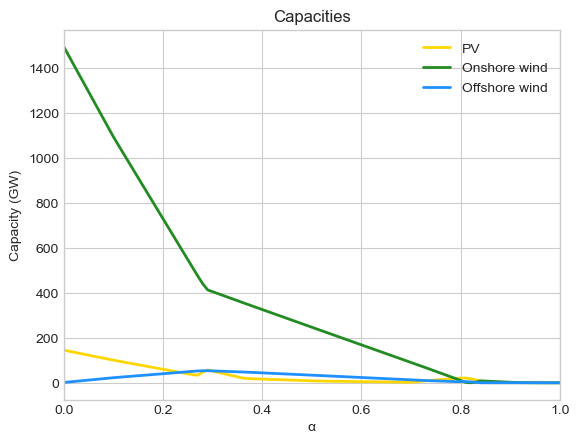

In [116]:
# Capacity Plot
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#Convert to GW --> plot
fig, ax = plt.subplots()

ax.plot(results_df['alpha'], results_df['PV']/1000, linewidth=2.0, color='gold', label='PV')
ax.plot(results_df['alpha'], results_df['ON']/1000, linewidth=2.0, color='forestgreen', label='Onshore wind')
ax.plot(results_df['alpha'], results_df['OF']/1000, linewidth=2.0, color='dodgerblue', label='Offshore wind')

ax.set(xlim=(0, 1), xlabel='\u03B1', ylabel='Capacity (GW)')

ax.legend()

ax.set_title('Capacities')

plt.show()

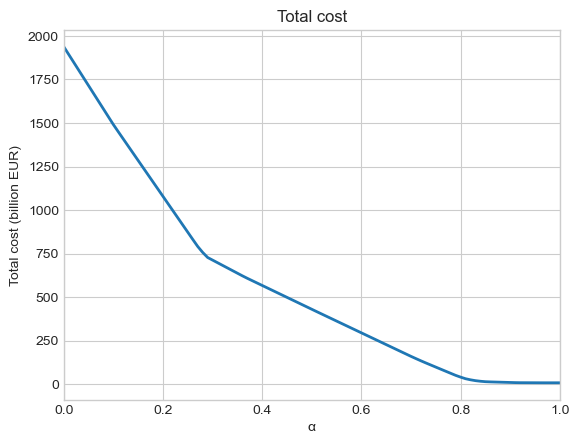

In [117]:
# Cost Plot
Z_billion = results_df['Z']/1000000000

# plot
fig, ax = plt.subplots()

ax.plot(alpha_values, Z_billion, linewidth=2.0)

ax.set(xlim=(0, 1), xlabel='\u03B1', ylabel='Total cost (billion EUR)')

ax.set_title('Total cost')

plt.show()


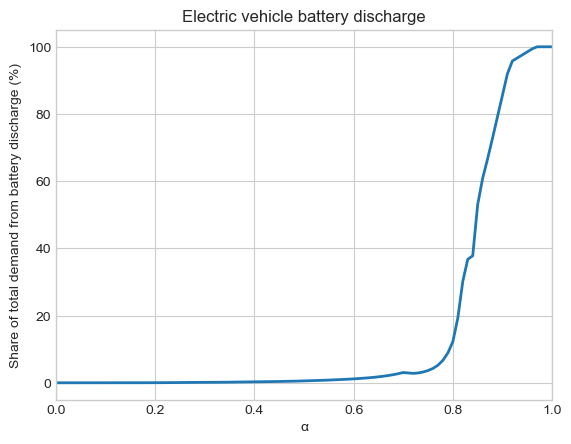

In [118]:
# V_dis Plot

share_V_dis = results_df['sum_V_discharge']/results_df['sum_d']*100

fig, ax = plt.subplots()

ax.plot(results_df['alpha'], share_V_dis, linewidth=2.0)

ax.set(xlim=(0, 1), xlabel='\u03B1', ylabel='Share of total demand from battery discharge (%)')

ax.set_title('Electric vehicle battery discharge')

plt.show()

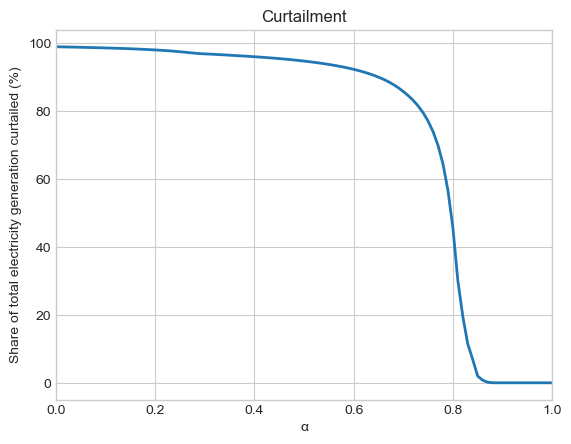

In [119]:
# Curtailment Plot (change to C/(d+C))
share_cur = results_df['sum_C']/(results_df['sum_d']+results_df['sum_C'])*100

# plot
fig, ax = plt.subplots()

ax.plot(results_df['alpha'], share_cur, linewidth=2.0)

ax.set(xlim=(0, 1), xlabel='\u03B1', ylabel='Share of total electricity generation curtailed (%)')

ax.set_title('Curtailment')

plt.show()

OLD MODELS

In [121]:
# List of alpha values
alpha_values = np.arange(1, 1.01, 0.01)

# Arrays to store results
N_pv_opt_array = np.zeros(len(alpha_values))
N_on_opt_array = np.zeros(len(alpha_values))
N_of_opt_array = np.zeros(len(alpha_values))
Z_array = np.zeros(len(alpha_values))
d_sum_array = np.zeros(len(alpha_values))
C_sum_array = np.zeros(len(alpha_values))
V_discharge_sum_array = np.zeros(len(alpha_values))

# Loop over each alpha value
for i, alpha in enumerate(alpha_values):

    # Load data into a Pandas DataFrame
    data = pd.read_csv(r'D:\Polit\Seminar (Energy Econ)\dCFdatavd_2020.csv')

    # Create a Pyomo model
    model = ConcreteModel()

    # Define the sets
    model.hours = Set(initialize=data.index, doc='Set of hours')

    # Define the parameters
    model.k_ipv = Param(default=435500)
    model.k_ion = Param(default=1252525)
    model.k_iof = Param(default=3458333)
    model.k_vv2g = Param(default=226.56)
    model.eta_charge = Param (default=0.924)
    model.eta_discharge = Param(default=0.903)
    model.E_s = Param(default=160425)
    model.alpha = Param(default=alpha_values[i])

    #Define data
    model.CF_pv = Param(model.hours, initialize=data['CF_pv'].to_dict())
    model.CF_on = Param(model.hours, initialize=data['CF_on'].to_dict())
    model.CF_of = Param(model.hours, initialize=data['CF_of'].to_dict())
    model.pv2g = Param(model.hours, initialize=data['pv2g'].to_dict())
    model.d_ev = Param(model.hours, initialize=data['d_ev'].to_dict())
    #model.k_vv2g = Param(model.hours, initialize=data['k_vv2g'].to_dict())

    # Define the variables
    model.N_pv = Var(domain=NonNegativeReals, initialize=0)
    model.N_on = Var(domain=NonNegativeReals, initialize=0)
    model.N_of = Var(domain=NonNegativeReals, initialize=0)
    model.V = Var(model.hours, domain=NonNegativeReals)
    model.V_charge = Var(model.hours, domain=NonNegativeReals)
    model.V_discharge = Var(model.hours, domain=NonNegativeReals)
    model.C = Var(model.hours, domain=NonNegativeReals)

    # Market balance constraints
    model.d1 = Constraint(model.hours, rule=lambda model, h: model.CF_pv[h] * model.N_pv +
                                                    model.CF_on[h] * model.N_on +
                                                    model.CF_of[h] * model.N_of + model.V_discharge[h] == data['d'][h] + model.C[h])

    #State of charge constraint
    def s1_constraint(model,h):
        if h == model.hours.first():
            return model.V[h] == model.alpha*model.E_s / 2
        else: 
            return model.V[h] == model.V[h-1] + model.eta_charge * model.V_charge[h] - model.V_discharge[h]/model.eta_discharge - model.alpha*data['d_ev'][h]
    model.s1 = Constraint(model.hours, rule = s1_constraint)

    """No free lunch"""
    model.s2 = Constraint(rule=lambda model:  model.V[model.hours.first()] == model.V[model.hours.last()])

    """Maximum energy storage must be less or equal to capacity"""
    model.s3 = Constraint(model.hours, rule=lambda model, h: model.V[h] <= model.alpha*model.E_s)

    # Charging and discharging constraints
    """ Maximum discharge rate within a single hour """
    model.disc1 = Constraint(model.hours, rule=lambda model, h: model.V_discharge[h] <= model.alpha*data['pv2g'][h])

    """ Maximum charge rate within a single hour """
    model.char1 = Constraint(model.hours, rule=lambda model, h: model.V_charge[h] <= model.alpha*data['pv2g'][h])

    # Define objective function
    def obj_expression(model):
        return model.k_ipv * model.N_pv + model.k_ion * model.N_on + model.k_iof * model.N_of + model.k_vv2g * sum(model.V_discharge[h] for h in model.hours)

    model.Z = Objective(expr=obj_expression(model), sense=minimize)

    # Solve the optimization problem
    solver = SolverFactory('glpk')
    solver.solve(model)


    # Retrieve the optimal values of decision variables
    N_pv_opt = model.N_pv()
    N_on_opt = model.N_on()
    N_of_opt = model.N_of()
    Z_opt = model.Z()
    sum_C = [sum(model.C[h]() for h in model.hours)][0]
    sum_d = [sum(data['d'][h] for h in model.hours)][0]
    sum_V_discharge = [sum(model.V_discharge[h]() for h in model.hours)][0]

    # Store results in arrays
    N_pv_opt_array[i] = N_pv_opt
    N_on_opt_array[i] = N_on_opt
    N_of_opt_array[i] = N_of_opt
    Z_array[i] = Z_opt
    d_sum_array[i] = sum_d
    C_sum_array[i] = sum_C
    V_discharge_sum_array[i] = sum_V_discharge

    print([i])


[0]
[1]


In [122]:
# Create a dataframe from the arrays
results_df = pd.DataFrame({
    'alpha': alpha_values,
    'PV': N_pv_opt_array,
    'ON': N_on_opt_array,
    'OF': N_of_opt_array,
    'Z': Z_array,
    'sum_d': d_sum_array,
    'sum_C': C_sum_array,
    'sum_V_discharge': V_discharge_sum_array
})

# Print the results
print(results_df.head(2))

   alpha   PV   ON   OF             Z         sum_d  sum_C  sum_V_discharge
0   1.00  0.0  0.0  0.0  7.927801e+09  3.499206e+07    0.0     3.499206e+07
1   1.01  0.0  0.0  0.0  7.927801e+09  3.499206e+07    0.0     3.499206e+07


In [ ]:
# Load data into a Pandas DataFrame
data = pd.read_csv(r'D:\Polit\Seminar (Energy Econ)\dCFdatavd.csv')

# Create a Pyomo model
model = ConcreteModel()

# Define the sets
model.hours = Set(initialize=data.index, doc='Set of hours')

# Define the parameters
model.k_ipv = Param(default=40)
model.k_ion = Param(default=30)
model.k_iof = Param(default=46)
model.k_vv2g = Param(default=226.56)
model.eta_charge = Param (default=0.924)
model.eta_discharge = Param(default=0.903)
model.E_s = Param(default=160425)
model.alpha = Param(default=0.25)

#Define data
model.CF_pv = Param(model.hours, initialize=data['CF_pv'].to_dict())
model.CF_on = Param(model.hours, initialize=data['CF_on'].to_dict())
model.CF_of = Param(model.hours, initialize=data['CF_of'].to_dict())
model.pv2g = Param(model.hours, initialize=data['pv2g'].to_dict())
model.d_ev = Param(model.hours, initialize=data['d_ev'].to_dict())

# Define the variables
model.N_pv = Var(domain=NonNegativeReals, initialize=0)
model.N_on = Var(domain=NonNegativeReals, initialize=0)
model.N_of = Var(domain=NonNegativeReals, initialize=0)
model.V = Var(model.hours, domain=NonNegativeReals)
model.V_charge = Var(model.hours, domain=NonNegativeReals)
model.V_discharge = Var(model.hours, domain=NonNegativeReals)
model.C = Var(model.hours, domain=NonNegativeReals)

# Market balance constraints
model.d1 = Constraint(model.hours, rule=lambda model, h: model.CF_pv[h] * model.N_pv +
                                                   model.CF_on[h] * model.N_on +
                                                   model.CF_of[h] * model.N_of + model.V_discharge[h] == data['d'][h] + model.C[h])

#State of charge constraint
def s1_constraint(model,h):
    if h == model.hours.first():
        return model.V[h] == model.alpha*model.E_s / 2
    else: 
        return model.V[h] == model.V[h-1] + model.eta_charge * model.V_charge[h] - model.V_discharge[h]/model.eta_discharge - data['d_ev'][h]
model.s1 = Constraint(model.hours, rule = s1_constraint)

"""No free lunch"""
model.s2 = Constraint(rule=lambda model:  model.V[model.hours.first()] == model.V[model.hours.last()])

"""Maximum energy storage must be less or equal to capacity"""
model.s3 = Constraint(model.hours, rule=lambda model, h: model.V[h] <= model.alpha*model.E_s)

# Charging and discharging constraints
""" Maximum discharge rate within a single hour """
model.disc1 = Constraint(model.hours, rule=lambda model, h: model.V_discharge[h] <= model.alpha*data['pv2g'][h])

""" Maximum charge rate within a single hour """
model.char1 = Constraint(model.hours, rule=lambda model, h: model.V_charge[h] <= model.alpha*data['pv2g'][h])

# Define objective function
def obj_expression(model):
    return model.k_ipv * model.N_pv + model.k_ion * model.N_on + model.k_iof * model.N_of + model.k_vv2g * sum(model.V_discharge[h] for h in model.hours)

model.Z = Objective(expr=obj_expression(model), sense=minimize) # Use the defined objective expression with the 'h' variable

# Solve the optimization problem
solver = SolverFactory('glpk')
#solver.solve(model)
results = solver.solve(model,tee=True)

# Access the solution
print("N_pv =", model.N_pv())
print("N_on =", model.N_on())
print("N_of =", model.N_of())
print("Z =", model.Z())